In [1]:
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA device count: {torch.cuda.device_count()}")
    print(f"CUDA current device: {torch.cuda.current_device()}")
    print(f"CUDA memory allocated: {torch.cuda.memory_allocated(0) / 1e6:.2f} MB")
    print(f"CUDA memory reserved: {torch.cuda.memory_reserved(0) / 1e6:.2f} MB")

PyTorch version: 2.3.0+cu121
CUDA available: True
CUDA version: 12.1
CUDA device: NVIDIA GeForce GTX 1650 Ti
CUDA device count: 1
CUDA current device: 0
CUDA memory allocated: 0.00 MB
CUDA memory reserved: 0.00 MB


In [2]:
!pip install pandas matplotlib sikit-learn pillow

ERROR: Could not find a version that satisfies the requirement sikit-learn (from versions: none)
ERROR: No matching distribution found for sikit-learn

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

In [4]:
class MultiLabelDataset(Dataset):
    """
    Custom Dataset class for handling multi-label image data.
    data model
    """
    def __init__(self, csv_file, img_dir, transform=None):
        """
        Initialize the dataset.

        Parameters:
        - csv_file (str): Path to the CSV file containing image labels.
        - img_dir (str): Directory where images are stored.
        - transform (callable, optional): Optional transform to be applied on an image.
        """
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.classes = ['car', 'truck', 'pedestrian', 'bicyclist', 'light']

    def __len__(self):
        """
        Returns the number of unique images in the dataset.
        """
        return len(self.data['frame'].unique())

    def __getitem__(self, idx):
        """
        Get an image and its corresponding labels at a given index.

        Parameters:
        - idx (int): Index of the item to fetch.

        Returns:
        - image (Tensor): Image tensor after applying transformations (if any).
        - labels (Tensor): Tensor of shape (5,) indicating the presence of each class.
        """
        img_name = self.data['frame'].unique()[idx] # Get the image filename at the index
        img_data = self.data[self.data['frame'] == img_name] # Filter rows for this image
        
        image = Image.open(os.path.join(self.img_dir, img_name)).convert('RGB')
        draw = ImageDraw.Draw(image)

        labels = torch.zeros(5, dtype=torch.float32)
        for _, row in img_data.iterrows():
            class_id = int(row['class_id']) - 1  # Adjust to 0-based index
            labels[class_id] = 1
            
            # Draw bounding box
            draw.rectangle([row['xmin'], row['ymin'], row['xmax'], row['ymax']], outline="red", width=2)

        if self.transform:
            image = self.transform(image)

        return image, labels
    
    def plot_sample(self, idx):
        """
        Plot a sample image and its labels.

        Parameters:
        - idx (int): Index of the sample to plot.
        """
        image, labels = self.__getitem__(idx)
        plt.imshow(image.permute(1, 2, 0))
        plt.title(f"Labels: {[self.classes[i] for i in range(5) if labels[i] == 1]}")
        plt.axis('off')
        plt.show()

In [5]:
# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
# Create datasets and dataloaders
train_dataset = MultiLabelDataset('Data/labels_train.csv', 'Data/images', transform=transform)
val_dataset = MultiLabelDataset('Data/labels_trainval.csv', 'Data/images', transform=transform)
test_dataset = MultiLabelDataset('Data/labels_val.csv', 'Data/images', transform=transform)


In [7]:
# Create dataloaders
batch_size = 16  # Adjust based on your GPU memory
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [8]:
import torchvision.models as models
import torch.nn as nn

def get_model(num_classes=5):
    """
    Create and return a modified ResNet50 model for multi-label classification.

    Parameters:
    - num_classes (int): Number of output classes for the final layer.

    Returns:
    - model (nn.Module): The modified ResNet50 model.
    """

    model = models.resnet50(pretrained=True)
    
    # Freeze the base model
    for param in model.parameters():
        param.requires_grad = False
    
    # Modify the first layer
    model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
    
    # Modify the last layer
    in_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(in_features, 256),    #infeatures neuron to 256 neuron
        nn.ReLU(),                      #activation function
        nn.Dropout(0.5),                #dropout for regularization 
        nn.Linear(256, num_classes),    # 256 input neuron to 5 neuron 
        nn.Sigmoid()                    # Sigmoid activation for multi-label classification
    )
    
    return model

model = get_model()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)



c:\Users\sujal\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sujal\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
# Define loss function and optimizer
criterion = nn.BCELoss()
# Define the optimizer to update only the parameters of the modified final layer that is fully connected layer
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

In [10]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10,checkpoint_interval=2, checkpoint_dir='./checkpoints'):
    """
    Train the model and validate its performance over several epochs.

    Parameters:
    - model (nn.Module): The model to train.
    - train_loader (DataLoader): DataLoader for the training dataset.
    - val_loader (DataLoader): DataLoader for the validation dataset.
    - criterion (nn.Module): Loss function used for training.
    - optimizer (Optimizer): Optimizer used for updating model weights.
    - num_epochs (int): Number of epochs to train the model.
    - checkpoint_interval (int): Interval for saving model checkpoints.
    - checkpoint_dir (str): Directory to save checkpoints.

    Returns:
    - train_losses (list): List of training losses per epoch.
    - val_losses (list): List of validation losses per epoch.
    - train_accuracies (list): List of training accuracies per epoch.
    - val_accuracies (list): List of validation accuracies per epoch.
    """
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()   # Zero the gradients
            outputs = model(images) # Forward pass
            loss = criterion(outputs, labels)   # Compute loss
            loss.backward() # Backward pass
            optimizer.step()    # Update model parameters
            
            train_loss += loss.item()
            predicted = (outputs > 0.5).float()
            train_correct += (predicted == labels).sum().item()
            train_total += labels.numel()
        
        train_loss /= len(train_loader)
        train_accuracy = train_correct / train_total
        
        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        
        with torch.no_grad():  # No need to compute gradients during validation
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                predicted = (outputs > 0.5).float()
                val_correct += (predicted == labels).sum().item()   # Count correct predictions
                val_total += labels.numel()
        
        val_loss /= len(val_loader)     # Average validation loss
        val_accuracy = val_correct / val_total      # Validation accuracy
        
        # Record metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
              f'Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}')
        
        # Checkpointing
        if (epoch + 1) % checkpoint_interval == 0 or (epoch + 1) == num_epochs:
            checkpoint_path = f'{checkpoint_dir}/model_epoch_{epoch+1}.pth'
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_accuracy': train_accuracy,
                'val_accuracy': val_accuracy,
            }, checkpoint_path)
            print(f'Checkpoint saved at {checkpoint_path}')
    
    return train_losses, val_losses, train_accuracies, val_accuracies


In [11]:
# Train the model
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer)



Epoch 1/10, Train Loss: 0.3477, Val Loss: 0.3181, Train Acc: 0.8574, Val Acc: 0.8606
Epoch 2/10, Train Loss: 0.3253, Val Loss: 0.3123, Train Acc: 0.8633, Val Acc: 0.8647
Checkpoint saved at ./checkpoints/model_epoch_2.pth
Epoch 3/10, Train Loss: 0.3168, Val Loss: 0.3039, Train Acc: 0.8663, Val Acc: 0.8662
Epoch 4/10, Train Loss: 0.3120, Val Loss: 0.3033, Train Acc: 0.8668, Val Acc: 0.8648
Checkpoint saved at ./checkpoints/model_epoch_4.pth
Epoch 5/10, Train Loss: 0.3064, Val Loss: 0.3017, Train Acc: 0.8686, Val Acc: 0.8648
Epoch 6/10, Train Loss: 0.3049, Val Loss: 0.2944, Train Acc: 0.8688, Val Acc: 0.8699
Checkpoint saved at ./checkpoints/model_epoch_6.pth
Epoch 7/10, Train Loss: 0.3025, Val Loss: 0.3001, Train Acc: 0.8693, Val Acc: 0.8671
Epoch 8/10, Train Loss: 0.2992, Val Loss: 0.2990, Train Acc: 0.8710, Val Acc: 0.8674
Checkpoint saved at ./checkpoints/model_epoch_8.pth
Epoch 9/10, Train Loss: 0.2955, Val Loss: 0.2871, Train Acc: 0.8724, Val Acc: 0.8755
Epoch 10/10, Train Loss: 0.

In [17]:
#saving the model
torch.save(model.state_dict(), 'multi_label_classifier.pth')

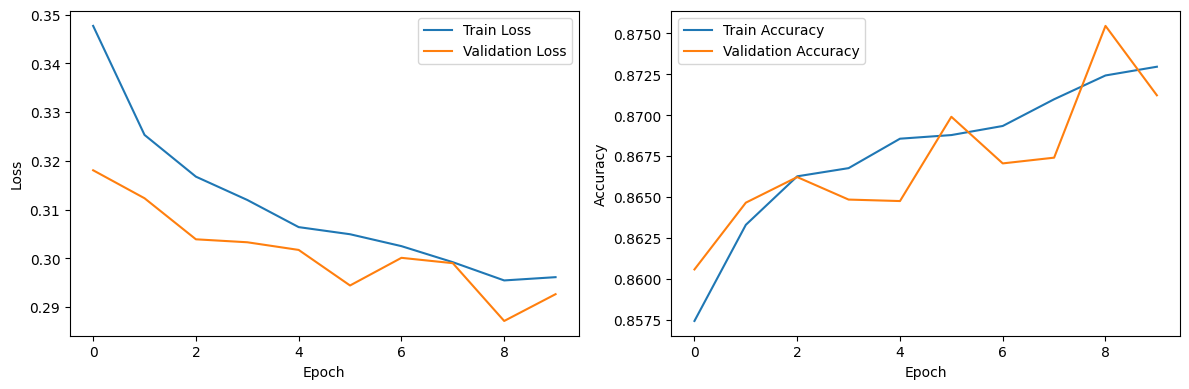

In [13]:
# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import torch

def calculate_metrics(model, data_loader):
    """
    calculate precision, recall, f1-score
    """
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = (outputs > 0.5).float()
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    precision = precision_score(all_labels, all_preds, average='samples')
    recall = recall_score(all_labels, all_preds, average='samples')
    f1 = f1_score(all_labels, all_preds, average='samples')
    
    return precision, recall, f1

precision, recall, f1 = calculate_metrics(model, test_loader)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')


Precision: 0.9674, Recall: 0.6692, F1 Score: 0.7549
